In [64]:
import mnist
import numpy as np
import scipy.ndimage
from tqdm import tqdm
import os 
from os import path
import matplotlib.pyplot as plt 
from cv2 import cv2

In [192]:
def get_rotations(img, rotation_steps):
    # print(rotation_steps) # 36 degrees at each rotation step 
    for rot in rotation_steps:
        img = scipy.ndimage.rotate(img, rot, reshape=False)
        yield img

def binarize(img):
    return img > 127

def heal_image(img, seq_len):
    rotations = []
    rotation_steps = [360*2/seq_len]*seq_len
    for idx, rotation in enumerate(get_rotations(img, rotation_steps)):
        rotations.append(binarize(rotation))
    return rotations, rotation_steps

In [45]:
class HealingMNIST():
    def __init__(self, filepath, seq_len=5, digits=range(10), train_len = 10000, test_len = 1000):
        self.mnist_train = [(img, label) for img, label in zip(mnist.train_images()[:train_len], mnist.train_labels()[:train_len]) if label in digits]
        self.mnist_test = [(img, label) for img, label in zip(mnist.test_images()[:test_len], mnist.test_labels()[:test_len]) if label in digits]        
        
        train_images = []
        test_images = []

        self.seq_len = seq_len 

    def generate_train(self): 
        # remove the saving function 
        for i, (img, label) in tqdm(enumerate(self.mnist_train)):
            train_img, train_rot = heal_image(img, self.seq_len)
            train_img = np.asarray(train_img).astype(np.float32)
            image = np.zeros((self.seq_len, 32,32))
            image[:, 2:30, 2:30] = train_img
        
        return image 

healing_mnist = HealingMNIST(filepath = None, seq_len = 20, train_len= 2, test_len=0)

In [46]:
sample = healing_mnist.generate_train()

2it [00:00, 129.27it/s]

[36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0]
[36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0]


(20, 32, 32)


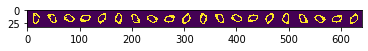

In [49]:
print(sample.shape)
plt.imshow(np.concatenate(sample, axis = 1))

### Zoom 

Now we test zoom, using zoom from scipy.ndimage

In [113]:
def get_zoom(img, zoom_steps):
    print(zoom_steps) # 36 degrees at each rotation step 
    for zoom_factor in zoom_steps:
        img = cv2_clipped_zoom(img, zoom_factor)
        yield img

def zoom_image(img, seq_len):
    zoom_list = []
    zoom_steps = [0.999, 1.001]* int(seq_len)
    for idx, zoom in enumerate(get_zoom(img, zoom_steps)):
        zoom_list.append(binarize(zoom))
    return zoom_list, zoom_steps

class ZoomMNIST():
    def __init__(self, filepath, seq_len=5, digits=range(10), train_len = 10000, test_len = 1000):
        self.mnist_train = [(img, label) for img, label in zip(mnist.train_images()[:train_len], mnist.train_labels()[:train_len]) if label in digits]
        self.mnist_test = [(img, label) for img, label in zip(mnist.test_images()[:test_len], mnist.test_labels()[:test_len]) if label in digits]        
        
        train_images = []
        test_images = []

        self.seq_len = seq_len 

    def generate_train(self): 
        # remove the saving function 
        for i, (img, label) in tqdm(enumerate(self.mnist_train)):
            train_img, train_rot = zoom_image(img, self.seq_len)
            train_img = np.asarray(train_img).astype(np.float32)
            image = np.zeros((self.seq_len, 32,32))
            image[:, 2:30, 2:30] = train_img
        
        return image 

zoom_mnist = ZoomMNIST(filepath = None, seq_len = 20, train_len= 1, test_len=0)

1it [00:00, 247.41it/s]

[0.999, 1.001, 0.999, 1.001, 0.999, 1.001, 0.999, 1.001, 0.999, 1.001, 0.999, 1.001, 0.999, 1.001, 0.999, 1.001, 0.999, 1.001, 0.999, 1.001]


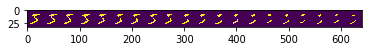

In [114]:
sample = zoom_mnist.generate_train()
plt.imshow(np.concatenate(sample, axis = 1))

In [72]:
def cv2_clipped_zoom(img, zoom_factor=0):
    """
    Source: https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
    
    Center zoom in/out of the given image and returning an enlarged/shrinked view of 
    the image without changing dimensions
    ------
    Args:
        img : ndarray
            Image array
        zoom_factor : float
            amount of zoom as a ratio [0 to Inf). Default 0.
    ------
    Returns:
        result: ndarray
           numpy ndarray of the same shape of the input img zoomed by the specified factor.          
    """
    if zoom_factor == 0:
        return img


    height, width = img.shape[:2]
    # print(height, width) # It's also the final desired shape
    new_height, new_width = int(height * zoom_factor), int(width * zoom_factor)
    
    ### Crop only the part that will remain in the result (more efficient)
    # Centered bbox of the final desired size in resized (larger/smaller) image coordinates
    y1, x1 = max(0, new_height - height) // 2, max(0, new_width - width) // 2
    y2, x2 = y1 + height, x1 + width
    bbox = np.array([y1,x1,y2,x2])
    # Map back to original image coordinates
    bbox = (bbox / zoom_factor).astype(int)
    y1, x1, y2, x2 = bbox
    cropped_img = img[y1:y2, x1:x2]
    
    # Handle padding when downscaling
    resize_height, resize_width = min(new_height, height), min(new_width, width)
    pad_height1, pad_width1 = (height - resize_height) // 2, (width - resize_width) //2
    pad_height2, pad_width2 = (height - resize_height) - pad_height1, (width - resize_width) - pad_width1
    pad_spec = [(pad_height1, pad_height2), (pad_width1, pad_width2)] + [(0,0)] * (img.ndim - 2)
    
    result = cv2.resize(cropped_img, (resize_width, resize_height))
    result = np.pad(result, pad_spec, mode='constant')
    assert result.shape[0] == height and result.shape[1] == width
    return result

In [69]:
img = np.random.randn(32, 32)
zoomed = cv2_clipped_zoom(img, 2)

32 32
(32, 32)


# Shifting instead

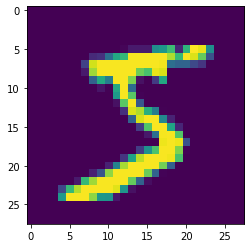

In [118]:
img = mnist.train_images()[0]
plt.imshow(img)

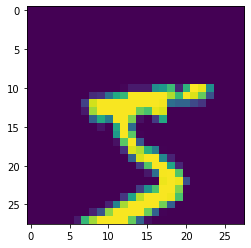

In [130]:
rolled_img = np.roll(img, 5, axis = 0)
rolled_img[:5,:] = 0
plt.imshow(rolled_img)

In [194]:
def shift_left(img, amt = -2): 
    left_img = np.roll(img, amt, axis = 1)
    left_img[:,amt:] = 0 

    return left_img

def shift_right(img, amt = 2): 
    right_img = np.roll(img, amt, axis = 1)
    right_img[:,:amt] = 0 

    return right_img

def shift_down(img, amt = 2): 
    down_img = np.roll(img, amt, axis = 0)
    down_img[:amt,:] = 0 

    return down_img

def shift_up(img, amt = -2): 
    down_img = np.roll(img, amt, axis = 0)
    down_img[amt:,:] = 0 

    return down_img


left_img = shift_left(img, -1)
right_img = shift_right(img, 4)
down_img = shift_down(img, 10)
up_img = shift_up(img, -10)

# plt.imshow(left_img)
# plt.imshow(right_img)
# plt.imshow(down_img)
# plt.imshow(up_img)


In [195]:
def get_shifts(img, shift_steps):
    for shift_value in shift_steps:
        if shift_value == 0: 
            img = shift_down(img)
        elif shift_value == 1: 
            img = shift_up(img)
        elif shift_value == 2: 
            img = shift_left(img)
        elif shift_value == 3: 
            img = shift_right(img)
        
        yield img

In [196]:


def create_shift_sequence(seq_len): 
    shift_seq = []
    # 2 shifts to right, 2 shifts down, 2 shifts left, 2 shifts up
    # basic_cycle = [3, 0, 2, 1]
    basic_cycle = [1]

    shift_seq.extend(basic_cycle * int(seq_len//len(basic_cycle)))
    shift_seq.extend(basic_cycle[:(seq_len%len(basic_cycle))])
    
    return shift_seq

create_shift_sequence(20)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

1it [00:00, 169.02it/s]


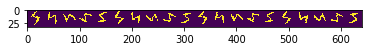

In [197]:
def shift_image(img, seq_len):
    shift_list = []
    shift_seq = create_shift_sequence(seq_len)
    for idx, shift in enumerate(get_shifts(img, shift_seq)):
        shift_list.append(binarize(shift))
    return shift_list, shift_seq

def transform_image(img, seq_len):
    """Rotate and shift. """
    transformed_images = []
    rotation_steps = [360*2/seq_len]*seq_len
    shift_steps = create_shift_sequence(seq_len)
    
    for idx, rotation in enumerate(get_rotations(img, rotation_steps)):
        img = next(get_shifts(rotation, shift_steps))
        transformed_images.append(binarize(img))
    
    return transformed_images


class eMNIST():
    def __init__(self, filepath, seq_len=5, digits=range(10), train_len = 10000, test_len = 1000):
        self.mnist_train = [(img, label) for img, label in zip(mnist.train_images()[:train_len], mnist.train_labels()[:train_len]) if label in digits]
        self.mnist_test = [(img, label) for img, label in zip(mnist.test_images()[:test_len], mnist.test_labels()[:test_len]) if label in digits]        
        
        train_images = []
        test_images = []

        self.seq_len = seq_len 

    def generate_train(self): 
        # remove the saving function 
        for i, (img, label) in tqdm(enumerate(self.mnist_train)):
            train_img = transform_image(img, self.seq_len)
            train_img = np.asarray(train_img).astype(np.float32)
            image = np.zeros((self.seq_len, 32,32))
            image[:, 2:30, 2:30] = train_img
        
        return image 

e_mnist = eMNIST(filepath = None, seq_len = 20, train_len= 1, test_len=0)
sample = e_mnist.generate_train()
plt.imshow(np.concatenate(sample, axis = 1))

# Combine shift and healing MNIST

Call this eMNIST

1it [00:00, 42.82it/s]

(20, 64, 64)


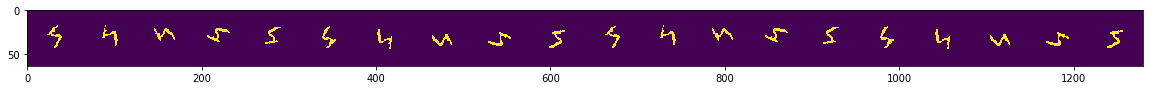

In [260]:
class eMNIST():
    def __init__(self, filepath, seq_len=5, digits=range(10), train_len = 10000, test_len = 1000):
        self.mnist_train = [(img, label) for img, label in zip(mnist.train_images()[:train_len], mnist.train_labels()[:train_len]) if label in digits]
        self.mnist_test = [(img, label) for img, label in zip(mnist.test_images()[:test_len], mnist.test_labels()[:test_len]) if label in digits]        
        
        train_images = []
        test_images = []

        self.seq_len = seq_len 

    def transform_image(self, img): 
        rotation_steps = [360*2/self.seq_len]*self.seq_len
        shift_steps = self.create_shift_sequence(self.seq_len) 
        transformed_images = []

        for rotate_value, shift_value in zip(rotation_steps, shift_steps): 
            # print(rotate_value, shift_value)
            img = self.rotate(img, rotate_value)
            img = self.shift(img, shift_value)
            transformed_images.append(img)

        return transformed_images

    def rotate(self, img, rotate_value): 
        img = scipy.ndimage.rotate(img, rotate_value, reshape=False)
        return img 

    def shift(self, img, shift_value): 
        if shift_value == 0: 
            img = self.shift_down(img)
        elif shift_value == 1: 
            img = self.shift_up(img)
        elif shift_value == 2: 
            img = self.shift_left(img)
        elif shift_value == 3: 
            img = self.shift_right(img)

        return img 

    def create_shift_sequence(self, seq_len): 
        shift_seq = []
        # basic_cycle = [3, 0, 2, 1] # right, down, left, up
        basic_cycle = [1] 

        shift_seq.extend(basic_cycle * int(seq_len//len(basic_cycle)))
        shift_seq.extend(basic_cycle[:(seq_len%len(basic_cycle))])
        
        return shift_seq
        
    def generate_train(self): 
        # remove the saving function 
        for i, (img, label) in tqdm(enumerate(self.mnist_train)):
            image = np.zeros((64,64))
            image[18:46, 18:46] = img
            train_img = self.transform_image(image)
            train_img = np.asarray(train_img).astype(np.float32)
            train_img = np.where(train_img > 127, 0.5, 0) # binarise
            print(train_img.shape)
        return train_img 

    def shift_left(self, img, amt = -2): 
        left_img = np.roll(img, amt, axis = 1)
        left_img[:,amt:] = 0 

        return left_img

    def shift_right(self, img, amt = 2): 
        right_img = np.roll(img, amt, axis = 1)
        right_img[:,:amt] = 0 

        return right_img

    def shift_down(self, img, amt = 2): 
        down_img = np.roll(img, amt, axis = 0)
        down_img[:amt,:] = 0 

        return down_img

    def shift_up(self, img, amt = -2): 
        down_img = np.roll(img, amt, axis = 0)
        down_img[amt:,:] = 0 

        return down_img

e_mnist = eMNIST(filepath = None, seq_len = 20, train_len= 1, test_len=0)
sample = e_mnist.generate_train()
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(np.concatenate(sample, axis = 1))
# print(sample)

In [ ]:
# One way will be to rotate in a 28 dimension image 
# and put that in a 64 dim image 
# shift in the 64 image vector 
# crop out the 28 vector 
# rotate and repeat 

# Not sure if this makes sense 